In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.close('all')

In [2]:
# load in Jones data
df = pd.read_pickle('output/features_svm')

# load in Gruendl data
df2 = pd.read_pickle('output/features_svm_gruendl_testdata')

In [3]:
# for simplicity, we shall consider the binary classification 'YSO' versus 'non-YSO'.
# I label all subgroups 'YSO1', 'YSO2', 'YSO3', 'YSO4', 'HII', and 'HII/YSO3' sources as 'YSO'
# all other objects (background galaxies, AGB stars, PNe, etc.) will fall in the 'non-YSO' class.
df['class'] = 'non-YSO'
df['class'][df['SpClass'] == 'YSO1'] = 'YSO'
df['class'][df['SpClass'] == 'YSO2'] = 'YSO'
df['class'][df['SpClass'] == 'YSO3'] = 'YSO'
df['class'][df['SpClass'] == 'YSO4'] = 'YSO'
df['class'][df['SpClass'] == 'HII'] = 'YSO'
df['class'][df['SpClass'] == 'HII/YSO3'] = 'YSO'

In [4]:
# create X,y data
train_X = df[['[8.0]','[4.5-8.0]','[8.0-24]','sigmadust']]
train_y = df['class']

In [5]:
# now use Gruendl's result to test the trained model. This list is separated in YSO and non-YSO list (background galaxies, AGB stars, evolved stars, PNe). The YSO list has shown to be ~99% accurate (Jones et al. 2017).
test_X = df2[['[8.0]','[4.5-8.0]','[8.0-24]','sigmadust']]
# df2['class'] = 'non-YSO'
test_y = df2['class']

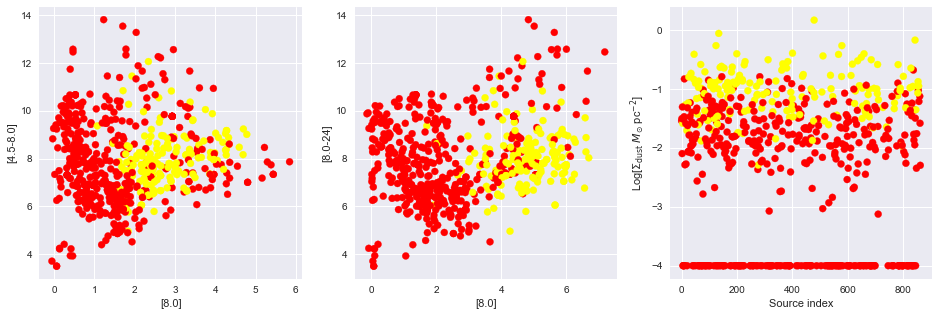

In [15]:
# Visualize the data
# first make color series to distinguish classes
col = train_y
col[train_y == 'non-YSO'] = 'red'
col[train_y == 'YSO'] = 'yellow'
        
# now plot the relevant features used in the SVM 
# NB plotting the hyperplane is difficult in high-dimensional space, therefore omitted.
fig = plt.figure(figsize=(16,5))
font = {'size':9}
plt.rc('font', **font)

plt.subplot(131)

plt.scatter(train_X['[4.5-8.0]'],train_X['[8.0]'],c=col)
plt.xlabel('[8.0]')
plt.ylabel('[4.5-8.0]')

plt.subplot(132)
plt.scatter(train_X['[8.0-24]'],train_X['[8.0]'],c=col)
plt.xlabel('[8.0]')
plt.ylabel('[8.0-24]')

plt.subplot(133)
plt.scatter(np.random.choice(train_X.index,len(train_X),replace=False),train_X['sigmadust'],c=col)
plt.xlabel('Source index')
plt.ylabel(r'Log[$\Sigma_\mathrm{dust}$ $M_\mathrm{\odot}$ pc$^{-2}$]')
plt.show()
#plt.savefig('output/visualize_features.pdf', dpi=150, bbox_inches='tight', pad_inches=0.2)

In [7]:
####################################
# TRAINING THE SVM
####################################

# import SVM modules
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import make_pipeline

In [8]:
# initiate model
svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(svc)

In [9]:
# get optimal parameters using a grid search cross-validation
# make sure optimal parameters fall in the middle of the grid
grid_pars = {'svc__C': [9e-2,1e-1,2e-1], 'svc__gamma': [0]}
grid = GridSearchCV(model, grid_pars)
grid.fit(train_X, train_y)
print grid.best_params_

{'svc__gamma': 0, 'svc__C': 0.1}


In [10]:
# train the model (Jones et al. 2017 data)
model = grid.best_estimator_
model.fit(train_X, train_y)

Pipeline(steps=[('svc', SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [11]:
# test with data the model hasn't seen (Gruendl et al. 2009 data)
fit_y = model.predict(test_X)

In [12]:
# print classification report --> average precision and recall of 0.87. Looking good for a first try!
print classification_report(test_y, fit_y)

             precision    recall  f1-score   support

        YSO       0.82      0.82      0.82       705
    non-YSO       0.90      0.90      0.90      1270

avg / total       0.87      0.87      0.87      1975



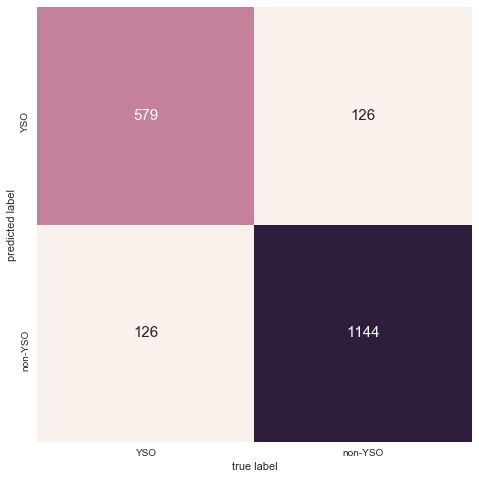

In [21]:
# plot confusion matrix
conf_mat = confusion_matrix(test_y,fit_y)

fig = plt.figure(figsize=(8,8))
font = {'size':15}
plt.rc('font', **font)

sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['YSO','non-YSO'],
            yticklabels=['YSO','non-YSO'])

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
#plt.savefig('output/confusion_matrix.pdf', dpi=150, bbox_inches='tight', pad_inches=0.2)